In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # Version 1.8

%matplotlib inline


class MacOSFile():

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        print("Reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                print("Reading bytes [%s,%s)..." % (idx, idx + batch_size),
                      end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                print("Done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size),
                  end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size

def pickle_load(file_path):
    """Wrapper of pickle.load"""
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))

In [2]:
# Load train and test sets.
tuning_hyperparams = False
train_X = pickle_load("../data/train_X.npy")
train_y = pickle_load("../data/train_y.npy")
if tuning_hyperparams:
    test_X = pickle_load("../data/validation_X.npy")
    test_y = pickle_load("../data/validation_y.npy")
else:
    test_X = pickle_load("../data/test_X.npy")
    test_y = pickle_load("../data/test_y.npy")

Reading total_bytes=11
Reading total_bytes=8213102745
Reading bytes [0,1073741824)...Done.
Reading bytes [1073741824,2147483648)...Done.
Reading bytes [2147483648,3221225472)...Done.
Reading bytes [3221225472,4294967296)...Done.
Reading bytes [4294967296,5368709120)...Done.
Reading bytes [5368709120,6442450944)...Done.
Reading bytes [6442450944,7516192768)...Done.
Reading bytes [7516192768,8213102745)...Done.
Reading total_bytes=11
Reading total_bytes=334336
Reading total_bytes=11
Reading total_bytes=2566914197
Reading bytes [0,1073741824)...Done.
Reading bytes [1073741824,2147483648)...Done.
Reading bytes [2147483648,2566914197)...Done.
Reading total_bytes=11
Reading total_bytes=104592


In [3]:
# Get shape of training set.
print("Training set (images) shape: {shape}".format(shape=train_X.shape))
print("Training set (labels) shape: {shape}".format(shape=train_y.shape))
# Get shape of test set.
print("Test set (images) shape: {shape}".format(shape=test_X.shape))
print("Test set (labels) shape: {shape}".format(shape=test_y.shape))
# Set input details.
image_size = 128
num_channels = 3
num_classes = 2
X = tf.placeholder("float", [None, image_size, image_size, num_channels])
y = tf.placeholder("float", [None, num_classes])

Training set (images) shape: (20887, 128, 128, 3)
Training set (labels) shape: (20887, 2)
Test set (images) shape: (6528, 128, 128, 3)
Test set (labels) shape: (6528, 2)


In [4]:
# Set key hyperparameters.
num_epochs = 20
learning_rate = 0.0001
batch_size = 256
num_hidden_layers = 6
num_filters_per_layer = [64, 128, 256, 512, 1024, 2048]
filter_sizes = [5, 3, 3, 3, 3, 1]
pooling_kernel_sizes = [2, 2, 2, 2, 2, 2]

In [5]:
def conv2d(X, W, b, stride=1):
    """tf.nn.conv2d() wrapper, with bias and relu activation."""
    # The first and last element of "strides" is example and
    # channel stride respectively.
    X = tf.nn.conv2d(X, W,
                     strides=[1, stride, stride, 1],
                     padding="SAME")
    X = tf.nn.bias_add(X, b)
    return tf.nn.relu(X)

def max_pool(X, kernel_size=2):
    # Stride of the kernel is always >= its size to prevent
    # overlap of pooling region.
    return tf.nn.max_pool(X,
                          ksize=[1, kernel_size, kernel_size, 1],
                          strides=[1, kernel_size, kernel_size, 1],
                          padding="SAME")

In [6]:
# Assumes stride when pooling is 1, and padding when convoluting is "SAME".
def find_final_size():
    final_size = image_size
    for i in range(len(pooling_kernel_sizes)):
        final_size /= pooling_kernel_sizes[i]
    return int(final_size)

In [7]:
# Create dictionaries for the weight and bias parameters.
weights = {
    "wc1": tf.get_variable("W0",
                           shape=(filter_sizes[0],
                                  filter_sizes[0],
                                  num_channels,
                                  num_filters_per_layer[0]),
                           initializer=tf.contrib.layers.xavier_initializer()), 
    "wc2": tf.get_variable("W1",
                           shape=(filter_sizes[1],
                                  filter_sizes[1],
                                  num_filters_per_layer[0],
                                  num_filters_per_layer[1]),
                           initializer=tf.contrib.layers.xavier_initializer()), 
    "wc3": tf.get_variable("W2",
                           shape=(filter_sizes[2],
                                  filter_sizes[2],
                                  num_filters_per_layer[1],
                                  num_filters_per_layer[2]),
                           initializer=tf.contrib.layers.xavier_initializer()), 
    "wc4": tf.get_variable("W3",
                           shape=(filter_sizes[3],
                                  filter_sizes[3],
                                  num_filters_per_layer[2],
                                  num_filters_per_layer[3]),
                           initializer=tf.contrib.layers.xavier_initializer()),
    "wc5": tf.get_variable("W4",
                           shape=(filter_sizes[4],
                                  filter_sizes[4],
                                  num_filters_per_layer[3],
                                  num_filters_per_layer[4]),
                           initializer=tf.contrib.layers.xavier_initializer()),
    "wc6": tf.get_variable("W5",
                           shape=(filter_sizes[5],
                                  filter_sizes[5],
                                  num_filters_per_layer[4],
                                  num_filters_per_layer[5]),
                           initializer=tf.contrib.layers.xavier_initializer()), 
    "wd1": tf.get_variable("W6",
                           shape=(find_final_size() * find_final_size() * num_filters_per_layer[5],
                                  num_filters_per_layer[5]),
                           initializer=tf.contrib.layers.xavier_initializer()), 
    "out": tf.get_variable("W7",
                           shape=(num_filters_per_layer[5],
                                  num_classes),
                           initializer=tf.contrib.layers.xavier_initializer()), 
}

biases = {
    "bc1": tf.get_variable("B0",
                           shape=(num_filters_per_layer[0]),
                           initializer=tf.contrib.layers.xavier_initializer()),
    "bc2": tf.get_variable("B1",
                           shape=(num_filters_per_layer[1]),
                           initializer=tf.contrib.layers.xavier_initializer()),
    "bc3": tf.get_variable("B2",
                           shape=(num_filters_per_layer[2]),
                           initializer=tf.contrib.layers.xavier_initializer()),
    "bc4": tf.get_variable("B3",
                           shape=(num_filters_per_layer[3]),
                           initializer=tf.contrib.layers.xavier_initializer()),
    "bc5": tf.get_variable("B4",
                           shape=(num_filters_per_layer[4]),
                           initializer=tf.contrib.layers.xavier_initializer()),
    "bc6": tf.get_variable("B5",
                           shape=(num_filters_per_layer[5]),
                           initializer=tf.contrib.layers.xavier_initializer()),
    "bd1": tf.get_variable("B6",
                           shape=(num_filters_per_layer[5]),
                           initializer=tf.contrib.layers.xavier_initializer()),
    "out": tf.get_variable("B7",
                           shape=(num_classes),
                           initializer=tf.contrib.layers.xavier_initializer()),
}

In [8]:
def conv_net(X, weights, biases):  
    conv_layer_1 = conv2d(X,
                          weights["wc1"],
                          biases["bc1"])
    pooled_conv_layer_1 = max_pool(conv_layer_1,
                                   kernel_size=pooling_kernel_sizes[0])
    conv_layer_2 = conv2d(pooled_conv_layer_1,
                          weights["wc2"],
                          biases["bc2"])
    pooled_conv_layer_2 = max_pool(conv_layer_2,
                                   kernel_size=pooling_kernel_sizes[1])
    conv_layer_3 = conv2d(pooled_conv_layer_2,
                          weights["wc3"],
                          biases["bc3"])
    pooled_conv_layer_3 = max_pool(conv_layer_3,
                                   kernel_size=pooling_kernel_sizes[2])
    conv_layer_4 = conv2d(pooled_conv_layer_3,
                          weights["wc4"],
                          biases["bc4"])
    pooled_conv_layer_4 = max_pool(conv_layer_4,
                                   kernel_size=pooling_kernel_sizes[3])
    conv_layer_5 = conv2d(pooled_conv_layer_4,
                          weights["wc5"],
                          biases["bc5"])
    pooled_conv_layer_5 = max_pool(conv_layer_5,
                                   kernel_size=pooling_kernel_sizes[4])
    conv_layer_6 = conv2d(pooled_conv_layer_5,
                          weights["wc6"],
                          biases["bc6"])
    pooled_conv_layer_6 = max_pool(conv_layer_6,
                                   kernel_size=pooling_kernel_sizes[5])
    fully_connected_layer = tf.reshape(pooled_conv_layer_6,
                                       [-1, weights["wd1"].get_shape().as_list()[0]])
    fully_connected_layer = tf.add(tf.matmul(fully_connected_layer,
                                             weights["wd1"]),
                                   biases["bd1"])
    fully_connected_layer = tf.nn.relu(fully_connected_layer)
    out = tf.add(tf.matmul(fully_connected_layer,
                           weights["out"]),
                 biases["out"])
    return out

In [9]:
predicted_labels = conv_net(X, weights, biases)
find_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_labels,
                                                              labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(find_loss)

is_correct_prediction = tf.equal(tf.argmax(predicted_labels, 1), tf.argmax(y, 1))
find_accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

In [10]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    train_loss = []
    train_accuracy = []
    summary_writer = tf.summary.FileWriter('./output', sess.graph)
    for epoch in range(num_epochs):
        for batch in range(len(train_X) // batch_size):
            batch_X = train_X[batch * batch_size : min((batch + 1) * batch_size, len(train_X))]
            batch_y = train_y[batch * batch_size : min((batch + 1) * batch_size, len(train_y))] 
            opt = sess.run(optimizer, feed_dict={X: batch_X, y: batch_y})
            # Calculate batch loss and accuracy.
            batch_loss, batch_accuracy = sess.run([find_loss, find_accuracy],
                                 feed_dict={X: batch_X, y: batch_y})
            train_loss.append(batch_loss)
            train_accuracy.append(batch_accuracy)
        print("Epoch " + str(epoch + 1) + \
              ", Training Loss: " + "{:.6f}".format(batch_loss) + \
              ", Training Accuracy: " + "{:.5f}".format(batch_accuracy))

    test_loss = []
    test_accuracy = []
    # Feeding the whole test set (> 5000 examples) takes more memory than we have (~11 GB).
    # Therefore, find "test_loss" and "test_accuracy" by taking batches of the test set.
    for batch in range(len(test_X)):
        batch_X = test_X[batch: min(batch + 1, len(test_X))]
        batch_y = test_y[batch: min(batch + 1, len(test_y))] 
        # Calculate batch loss and accuracy.
        batch_loss, batch_accuracy = sess.run([find_loss, find_accuracy],
                                              feed_dict={X: batch_X, y: batch_y})
        test_loss.append(batch_loss)
        test_accuracy.append(batch_accuracy)
    overall_loss = np.mean(test_loss)
    overall_accuracy = np.mean(test_accuracy)
    print("Test Loss: " + "{:.6f}".format(overall_loss) + \
          ", Test Accuracy: " + "{:.5f}".format(overall_accuracy))

    summary_writer.close()

Epoch 1, Training Loss: 0.020019, Training Accuracy: 0.99219
Epoch 2, Training Loss: 0.015520, Training Accuracy: 0.99609
Epoch 3, Training Loss: 0.008000, Training Accuracy: 1.00000
Epoch 4, Training Loss: 0.003867, Training Accuracy: 1.00000
Epoch 5, Training Loss: 0.002661, Training Accuracy: 1.00000
Epoch 6, Training Loss: 0.004003, Training Accuracy: 1.00000
Epoch 7, Training Loss: 0.002452, Training Accuracy: 1.00000
Epoch 8, Training Loss: 0.001522, Training Accuracy: 1.00000
Epoch 9, Training Loss: 0.000975, Training Accuracy: 1.00000
Epoch 10, Training Loss: 0.000840, Training Accuracy: 1.00000
Epoch 11, Training Loss: 0.000715, Training Accuracy: 1.00000
Epoch 12, Training Loss: 0.000193, Training Accuracy: 1.00000
Epoch 13, Training Loss: 0.001122, Training Accuracy: 1.00000
Epoch 14, Training Loss: 0.000196, Training Accuracy: 1.00000
Epoch 15, Training Loss: 0.000613, Training Accuracy: 1.00000
Epoch 16, Training Loss: 0.000315, Training Accuracy: 1.00000
Epoch 17, Trainin

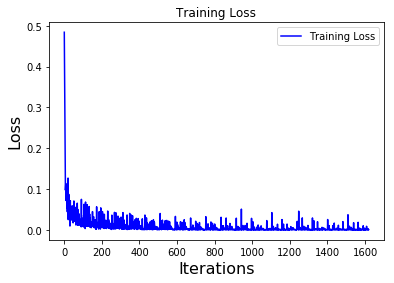

<Figure size 432x288 with 0 Axes>

In [11]:
plt.plot(range(len(train_loss)),
         train_loss,
         "b",
         label="Training Loss")
plt.title("Training Loss")
plt.xlabel("Iterations",
           fontsize=16)
plt.ylabel("Loss",
           fontsize=16)
plt.legend()
plt.figure()
plt.show()

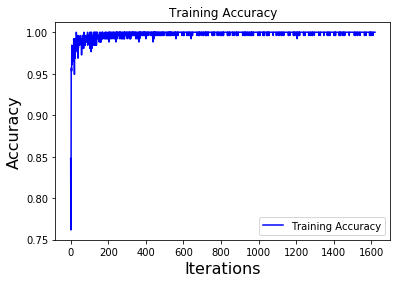

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(range(len(train_accuracy)),
         train_accuracy,
         "b",
         label="Training Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Iterations",
           fontsize=16)
plt.ylabel("Accuracy",
           fontsize=16)
plt.legend()
plt.figure()
plt.show()